#Q1. $\pi$ estimation with MCMC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


### (a). Uniform Marcov Chain Random Walk in the square

Both x and y are limited within [-1,1] and the distrubition of their densisty is uniform within that range.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 100000

# Joint porbability of X and Y, independant so 1/4
def target_function(xy):
    if np.all((-1.0 <= xy) & (xy <= 1.0)):
        return 1/4
    else:
        return 0.0


def metropolis_uniform(xy):
    # propose a move from a symmetric distrubition
    dx = np.random.normal(0, 0.4, 2)
    xy_new = xy + dx

    # count the number of move accepted
    accepted = 0

    if target_function(xy) == 0:
        p = 0
    else:
        p = target_function(xy_new) / target_function(xy)

    u = np.random.uniform()
    if u < p:
        accepted =1
        return accepted, xy_new

    else:
        return accepted, xy

xy = np.array([0.5, 0.5])
chain = [xy]
for i in range(1, N + 1):
      accepted, walk = metropolis_uniform(chain[-1])
      chain.append(walk)



Now we have generated a  random walk in the square we will

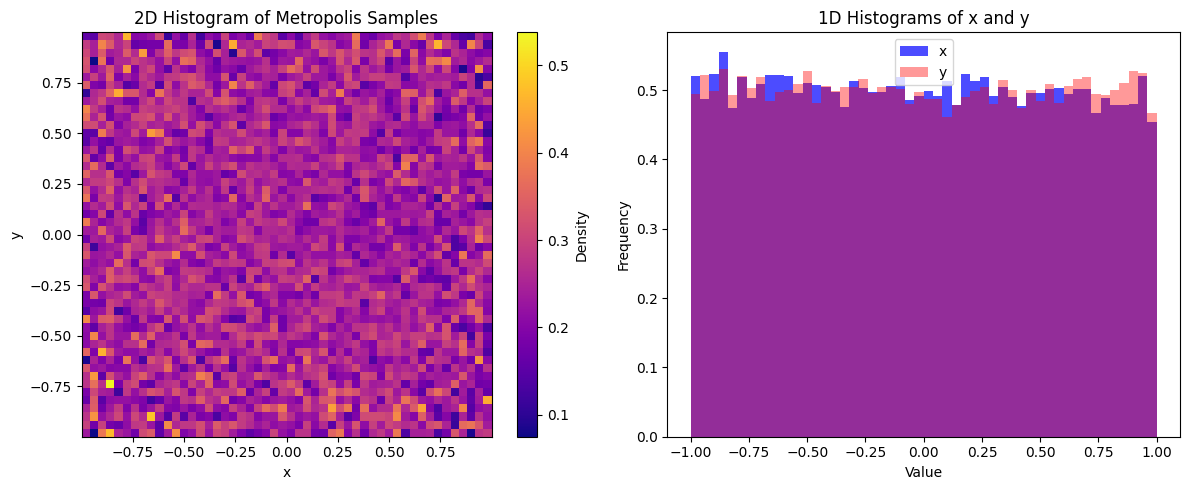

In [ ]:
uniform = np.array(chain)
x_vals = uniform[:, 0]
y_vals = uniform[:, 1]


# Create two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 2D histogram
h = axes[0].hist2d(x_vals, y_vals, bins=50, cmap='plasma', density=True)
fig.colorbar(h[3], ax=axes[0], label='Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D Histogram of Metropolis Samples')

# 1D histograms of x and y
axes[1].hist(x_vals, bins=50, alpha=0.7, label='x', color='blue', density=True)
axes[1].hist(y_vals, bins=50, alpha=0.4, label='y', color='red', density=True)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('1D Histograms of x and y')
axes[1].legend()

plt.tight_layout()
plt.show()

## (b). Convergence of the Estimator of $\pi$

By the ergodic theorem the mean of a function $g(x)$ using a long Markov chain generation that the stationary distribution converge to it , here it is $\pi$.

Cconsider $X_p = (x_p, y_p)$ generated by the Metropolis random walk on the unit square, and we take
$$
g(X_p) = \mathbb{1}_{\{x_p^2 + y_p^2 \le 1\}}.
$$

as the point in the unit circle.
Using monte carlo approximation
$$
\frac{\pi}{4} ≈ \frac{k}{n}
$$
as n goes to infinity.

Thus with the ergodic ,
\begin{align}
\mathbb{E}[\frac{\pi}{4}]
    &\approx \frac{1}{n} \sum_{p=1}^{n} g(X_p) \\
    &≈ \frac{1}{n} \sum_{p=1}^{n} \mathbb{1}_{\{x_p^2 + y_p^2 \le 1\}}.
\end{align}

Hence the estimate of $\pi$ is
$$
\hat{\pi} ≈ 4 \cdot \frac{1}{n} \sum_{p=1}^{n} \mathbb{1}_{\{x_p^2 + y_p^2 \le 1\}}.
$$

Final π estimate ≈ 3.15048


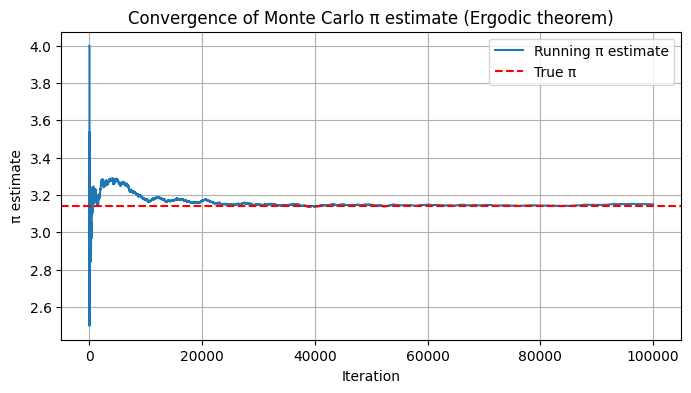

In [ ]:
def generate_random_walk_in_square(N, xy):
    chain = [xy]
    pi_list = []
    ratios = [0]
    n_circle = 0
    acceptance = 0
    for i in range(1, N + 1):
        accepted, walk = metropolis_uniform(chain[-1])
        chain.append(walk)

        # computing the acceptance ratio
        acceptance += accepted
        ratio = acceptance/i
        ratios.append(ratio)

        x,y = chain[i]
        if x**2 + y**2 <= 1.0:
            n_circle += 1

        pi_est = 4 * n_circle / i
        pi_list.append(pi_est)

    return np.array(chain), np.array(pi_list), ratios

N = 100000

_ , pi_list, ratios = generate_random_walk_in_square(N, xy)

print(f"Final π estimate ≈ {pi_list[-1]}")


plt.figure(figsize=(8,4))
plt.plot(pi_list, label='Running π estimate')
plt.axhline(np.pi, color='red', linestyle='--', label='True π')

plt.xlabel('Iteration')
plt.ylabel('π estimate')
plt.title('Convergence of Monte Carlo π estimate (Ergodic theorem)')
plt.legend()
plt.grid(True)
plt.show()



* Acceptance ratio

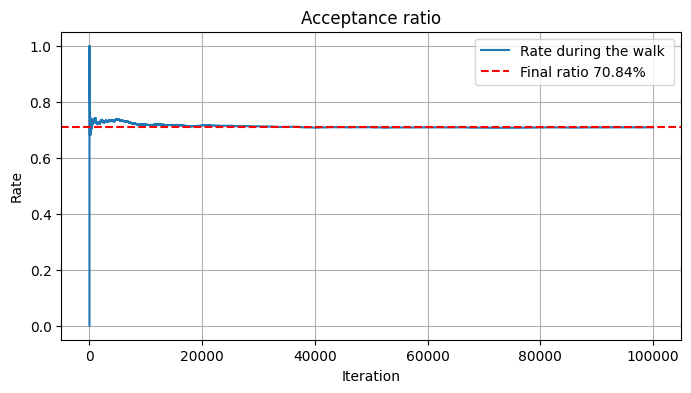

In [ ]:

plt.figure(figsize=(8,4))
plt.plot(ratios, label=f'Rate during the walk ')
plt.axhline(ratios[-1], color='red', linestyle='--', label=f'Final ratio {ratios[-1]*100:.2f}%')

plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.title('Acceptance ratio')
plt.legend()
plt.grid(True)
plt.show()

## (c). Error bars

The way we did in the previous CW1, we can not do that here to do plot the error bars. However the erro can be still theoritically computed using : $ \sigma(\hat \mu) = \sqrt{Var(\hat \mu)}$ where $Var({\hat \mu}) = \frac{Var(XY)}{L}$. We have assumed in the previous plot that the we had a IID. Unlike here we have random variables that depend on the previous ones so are correlated. Henc ethe formula will differ completely from what we had in the central theorem limit.

Reference : [Determining variance from sum of two random correlated variables StackExchange](https://math.stackexchange.com/questions/115518/determining-variance-from-sum-of-two-random-correlated-variables)

#Q2. Gaussian mixture

### (a). Sampling from the Gaussian mixture using metropolis

$p(x)  =  a_1p_1(x) + a_2p_2(x)$

Algorithm metropolis to sample from mixture of two gaussian while keeping track of the acceptaance ratio.

In [ ]:
n_samples = 100000

def gaussian(x, mu=0, sigma=1):
    """Compute Gaussian PDF value for x, given mean (mu) and std (sigma)."""
    coeff = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    return coeff * np.exp(exponent)

def gaussian_mixture(x, a1= 0.3, a2=0.7):
  p1 = gaussian(x, -20, 10)
  p2 = gaussian(x, 20, 10)
  return a1*p1 + a2*p2

def metropolis_gaussian(sigma, n_samples, burn_in=100):

    x = np.zeros(n_samples)
    x[0] = 0
    accepted = 0
    for i in range(1, n_samples):
        proposal = x[i-1] + np.random.normal(0, sigma)
        p_ratio = gaussian_mixture(proposal) / gaussian_mixture(x[i-1])
        alpha = min(1, p_ratio)

        # Accept or reject
        if np.random.rand() < alpha:
            x[i] = proposal
            accepted += 1
        else:
            x[i] = x[i-1]

      # computing the acceptance ratio

    ratio = accepted/n_samples


    return x[burn_in:], ratio


We will generate the variates from the three different sigma step

In [ ]:
# Sigma = 1
data_1, ratio_1 = metropolis_gaussian(1, n_samples)

# Sigma = 500
data_500, ratio_500 = metropolis_gaussian(500, n_samples)

# Sigma = 8
data_8, ratio_8 = metropolis_gaussian(8, n_samples)

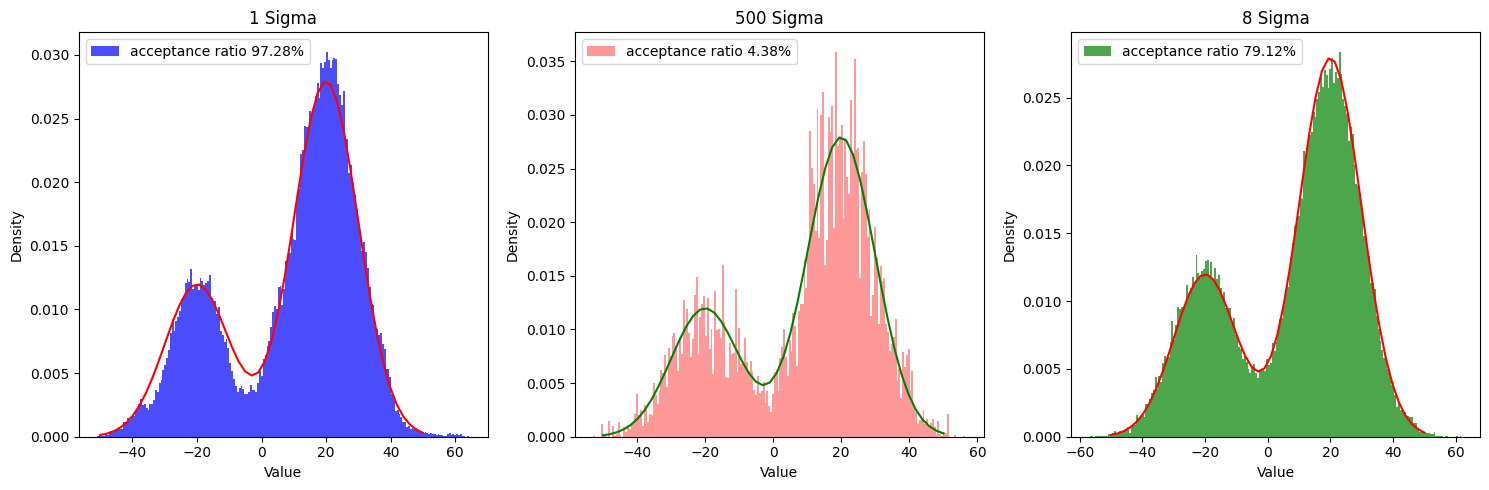

In [ ]:
# Create two subplots next to each other
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
xlim = np.linspace(-50,50)
#  histogram
axes[0].hist(data_1, bins=200, alpha=0.7,label=f'acceptance ratio {ratio_1*100:.2f}%', color='blue', density=True)
axes[0].plot(xlim, gaussian_mixture(xlim), color = 'red')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].set_title('1 Sigma')
axes[0].legend()



axes[1].hist(data_500, bins=200, alpha=0.4, label=f'acceptance ratio {ratio_500*100:.2f}%', color='red', density=True)
axes[1].plot(xlim, gaussian_mixture(xlim), color = 'green')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].set_title('500 Sigma')
axes[1].legend()

# 1D histograms of x and y

axes[2].hist(data_8, bins=200, alpha=0.7,  label=f'acceptance ratio {ratio_8*100:.2f}%', color='green', density=True)
axes[2].plot(xlim, gaussian_mixture(xlim), color = 'red')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].set_title('8 Sigma')
axes[2].legend()

plt.tight_layout()
plt.show()

###  (b). Results discussion

  The sigma is very related to the step of the random walk. If an analogy to stochastic gradient descent is to be made, an interpretation of a large step will be that the learning curve  will go up and down and maybe not be converging. On the other hand for a small step the algorithm would be likely to stuck in a local maxima. And for a reasonable value of step the learning curve will be good shaped.

  - $\sigma =1$ : Assume the that from the state $x_i$ , proposed state $x_j$ is generated. The fact that the value of the sigma will make the ratio of the propbability approx nearly 1,  as sshown with the acceptance rate to 98%. So that most the move will be accepted but with a slow convergence to the desired distrubition.

  - $\sigma=500$ : Nearly 5% of the moves are only accepted for this variance because once we reached a local maxima it  will reject other move that will be different from it or not good.



  - $\sigma = 8$ : From the analysis above with a reasonable step the algorithm will be wise to select which move to make for the walk which lead to a faster convergence.

  Reference : [Acceptance ratio in Metropolis-Hastings algorithm Stack-Exchange](https://stats.stackexchange.com/questions/27913/acceptance-ratio-in-metropolis-hastings-algorithm)

# Q3. Bayesian linear fit

### (a). Data generation from $y = ax+b+\sigma z$



In [ ]:
def linear(x):
  z = np.random.normal()
  return x + z

data = []
features = []
for _ in range(50):
  x = np.random.uniform(-10, 10)
  features.append(x)
  data.append(linear(x))

data = np.array(data)


* Plot and least-square linear fit using sckit learn

    Reference : [least-square linear (Linear Regression)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

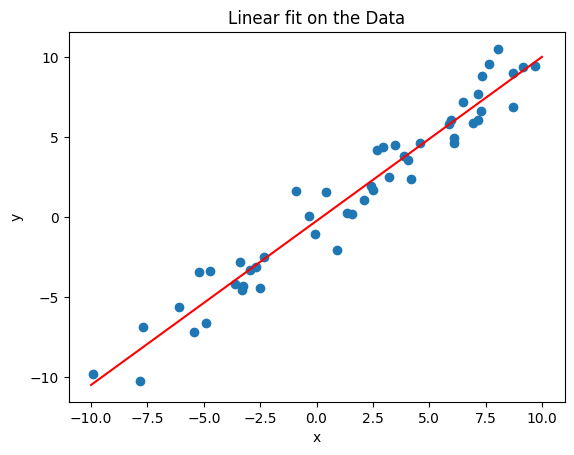

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.array(features).reshape(-1,1), data)

intercept = model.intercept_
slope = model.coef_[0]

def pred(x):
  return slope*x + intercept

xlim= np.linspace(-10, 10)
plt.scatter(features, data)
plt.plot(xlim, pred(xlim), color='red')
plt.title('Linear fit on the Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
intercept, slope

(np.float64(-0.23656303504777854), np.float64(1.0261614614336014))

### (b). The likelihood, prior  and the unormalized posterior

* The likelihood $p(D|θ)$ for this model .

    From the assumption that y = ax+b+$\sigma$z  → $y \sim N(ax+b , \sigma)$.
    So  for the Likelihood :

\begin{align}
p(D|\theta)
&= \prod_{i=1}^n
\frac{1}{\sigma \sqrt{2\pi}}
\exp\!\left(
-\frac{(y_i - (ax_i + b))^2}{2\sigma^2}
\right) \\[6pt]
&= (\sigma \sqrt{2\pi})^{-n}
\exp\!\left(
-\frac{1}{2\sigma^2}
\sum_{i=1}^n (y_i - ax_i - b)^2
\right) \\[6pt]
\end{align}

* To get the prior

    We have chosen the hyper-parameter from the original data
\begin{align*}
\hat a = 1 \text{ , }\hat \sigma_a = 1\\
\hat b = 0 \text{ , }\hat \sigma_b = 1 \\
\hat \sigma = 1 \text{ , }\hat \sigma_{\sigma} = 1 \\
\end{align*}


\begin{align}
p(\theta)
&= p(a)\,p(b)\,p(\sigma) \\[6pt]
&=
\frac{1}{\sqrt{2\pi}}
\exp\!\left(
-\frac{(a-1)^2}{2}
\right)
\cdot
\frac{1}{\sqrt{2\pi}}
\exp\!\left(
-\frac{b^2}{2}
\right)
\cdot
\frac{1}{\sqrt{2\pi}}
\exp\!\left(
-\frac{(\sigma-1)^2}{2}
\right) \\[6pt]
&= (\sqrt{2\pi})^{-3}
\exp\!\left(
-\frac{(a-1)^2}{2}
-\frac{b^2}{2}
-\frac{(\sigma-1)^2}{2}
\right)\\
&= (\sqrt{2\pi})^{-3}
\exp\!\left(
-\frac{(a-1)^2
-b^2
-(\sigma-1)^2}{2}
\right)
\end{align}

* For the unormalized posterior

\begin{align}
p(\theta|D)
&\propto p(D|\theta)\,p(\theta) \\[6pt]
&\propto
(\sqrt{2\pi}\sigma)^{-n}
\exp\!\left(
-\frac{1}{2\sigma^2}
\sum_{i=1}^n (y_i - ax_i - b)^2
\right)(\sqrt{2\pi})^{-3}
\exp\!\left(
-\frac{(a-1)^2
-b^2
-(\sigma-1)^2}{2}
\right) \\[6pt]
\end{align}


### (c). Sampling algorithm for the posterior using  MCMC

We will take the logarithm of the posterior so that teh product will change to summation. And also we will leave all the constant in the evidence $p(D)$.

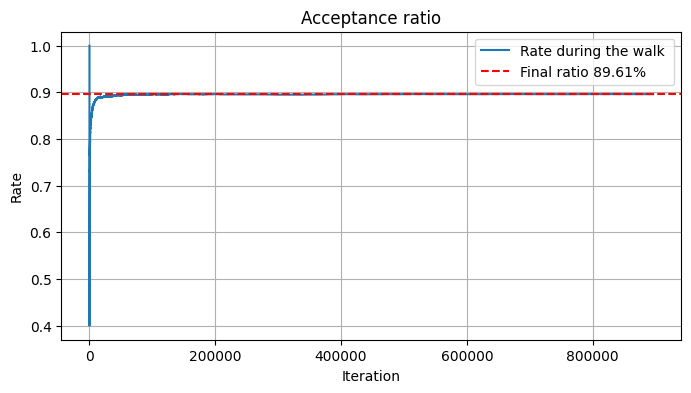

In [ ]:
# Algorithm that sample from the posterior
Lmax = 1000000

def unormalized_posterior(Y, X, thetas):
  n = len(Y)
  Y = np.asarray(Y)
  X = np.asarray(X)
  a , b ,sigma = thetas
  R = Y - a*X - b
  abc = (a-1)**2 - b**2 - (np.abs(sigma)-1)**2
  post = -n*np.log(np.abs(sigma)) - (2*sigma**2)**(-1)*R.T@R - abc/2
  return post

def metropolis_algorithm(Y, X, samples = 100000):
  chains = [np.array([0.24114767, -0.40449703, 0.41622711])]
  accepted = 0
  ratio = 0
  ratios = []
  for i in range(1,samples):
    #propose a move
    old_abc = chains[i-1]
    move = np.random.normal(0,0.01, (3,))
    new_abc = old_abc + move

    log_p = unormalized_posterior(Y, X, new_abc) -  unormalized_posterior(Y, X, old_abc)
    logu = np.log(np.random.uniform())
    if  logu<=log_p:
        old_abc = new_abc
        accepted+=1
        ratio = accepted/i
        ratios.append(ratio)
    chains.append(old_abc)
  return ratios,chains

# Simulate the trajectory
ratios, chain = metropolis_algorithm(data, features, Lmax)


plt.figure(figsize=(8,4))
plt.plot(ratios, label=f'Rate during the walk ')
plt.axhline(ratios[-1], color='red', linestyle='--', label=f'Final ratio {ratios[-1]*100:.2f}%')

plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.title('Acceptance ratio')
plt.legend()
plt.grid(True)
plt.show()

Convert to numpy array the chain list

In [ ]:
chain_mx = np.array(chain)

### (d). Histogram and the most probable values for the data

* For the parameters to find the most probable parameter we will check in the bin range where we have the most count.

In [ ]:
# Histogram of a and its probbale value
count, value_a = np.histogram(chain_mx[:,0], bins=100)
idx = np.argmax(count)
a_est = float(value_a[idx-1] + value_a[idx])/2

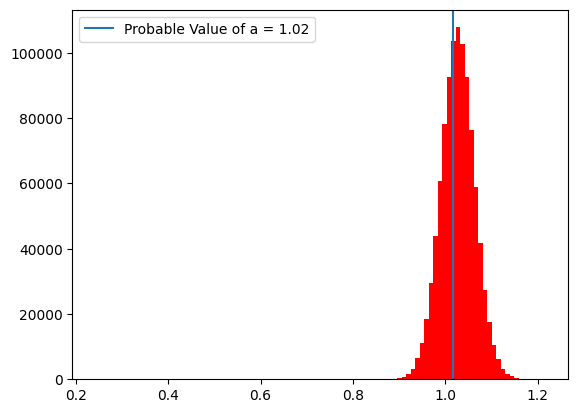

In [ ]:

plt.hist(chain_mx[:,0], bins=100, color='red')
plt.axvline(a_est, label=f"Probable Value of a = {a_est:.2f}")
plt.legend()
plt.show()


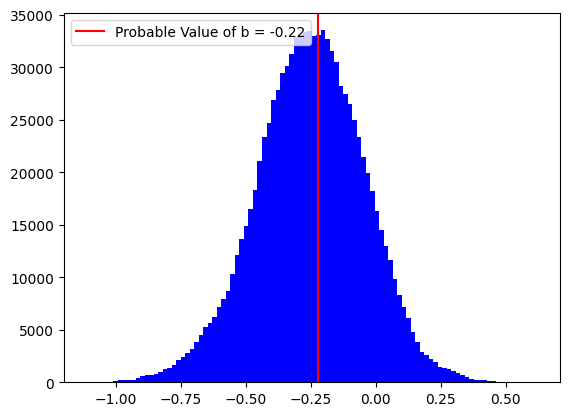

In [ ]:
# Histogram of b and its expected value

count, value_b = np.histogram(chain_mx[:,1], bins=100)
idx = np.argmax(count)

b_est = float(value_b[idx-1] + value_b[idx])/2

plt.hist(chain_mx[:,1], bins=100, color='blue')
plt.axvline(b_est, color='red', label=f"Probable Value of b = {b_est:.2f}")
plt.legend()
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3273113265.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(c_est, color='red', label=f"Probable Value of $\sigma$ = {c_est:.2f}")


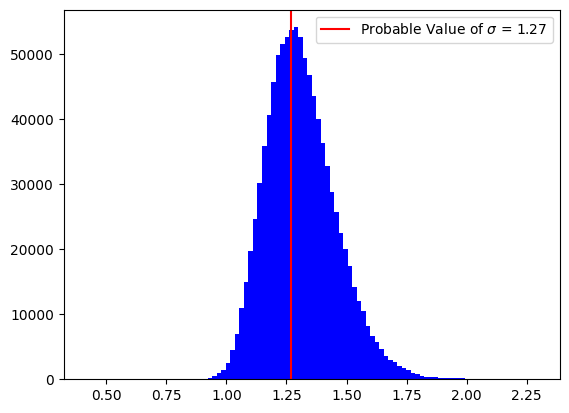

In [ ]:
# Histogram of c and its expected value

count, value_c = np.histogram(chain_mx[:,2], bins=100)
idx = np.argmax(count)

c_est = float(value_c[idx-1] + value_c[idx])/2

plt.hist(chain_mx[:,2], bins=100, color='blue')
plt.axvline(c_est, color='red', label=f"Probable Value of $\sigma$ = {c_est:.2f}")
plt.legend()
plt.show()

Acknowledgement : The logic and algorithm are mainly my work . Chatgpt and Gemini were used to debug and help fo the decoration of the plot.